# Comparison of H2 and stellar surface density

In [1]:
import os
import numpy as np
from astropy.table import Table, join, Column
import matplotlib.pyplot as plt
from astropy import units as u
from scipy import stats
from edge_pydb import EdgeTable
from edge_pydb.xy2hist import xy2hist
from edge_pydb.conversion import gc_polr, stmass_pc2, msd_co, ZOH_M13
params = {'mathtext.default': 'regular'} 
plt.rcParams.update(params)
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Read the observational values

In [2]:
try:
    hatab = EdgeTable('edge.pipe3d.hdf5', path='flux_elines_sm', 
                      cols=['Name','ix','iy','flux_Halpha','flux_Hbeta',
                            'e_flux_Halpha','flux_[NII]6583','flux_[OIII]5007','EW_Halpha'])
    sttab = EdgeTable('edge.pipe3d.hdf5', path='SSP_sm', 
                      cols=['Name','ix','iy','mass_ssp'])
    cotab = EdgeTable('edge.comom_smo7.hdf5', path='smo')
    print('Working on full EDGE database')
except:
    hatab = EdgeTable('NGC4047.pipe3d.hdf5', path='flux_elines_sm', 
                      cols=['Name','ix','iy','flux_Halpha','flux_Hbeta',
                            'e_flux_Halpha','flux_[NII]6583','flux_[OIII]5007','EW_Halpha'])
    sttab = EdgeTable('NGC4047.pipe3d.hdf5', path='SSP_sm', 
                      cols=['Name','ix','iy','mass_ssp'])
    cotab = EdgeTable('NGC4047.comom_smo7.hdf5', path='smo')
    print('Working on NGC 4047 data')

Working on NGC 4047 data


In [3]:
cotab.join(hatab, keys=['Name','ix','iy'])
cotab.join(sttab, keys=['Name','ix','iy'])
# For stellar surface density we need distance
califa = EdgeTable('edge_califa.csv', cols=['Name','caDistMpc'])
cotab.join(califa)
# For normalized radius we need R25
leda    = EdgeTable('edge_leda.csv', cols=['Name','ledaD25'])
cotab.join(leda)
print(cotab.colnames)

['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'emom0max', 'mom0', 'emom0', 'flux_Halpha', 'flux_Hbeta', 'e_flux_Halpha', 'flux_[NII]6583', 'flux_[OIII]5007', 'EW_Halpha', 'mass_ssp', 'caDistMpc', 'ledaD25']


## Calculate physical values using functions in conversion.py

In [4]:
ZOH = ZOH_M13(cotab, method='o3n2', err=False)
print('Calculated {} for {} points'.format('ZOH',len(ZOH)))
sig_star = stmass_pc2(cotab['mass_ssp'], dist=cotab['caDistMpc'].quantity)
print('Calculated {} for {} points'.format('sig_star',len(sig_star)))
sig_mol  = msd_co(cotab['mom0'])
print('Calculated {} for {} points'.format('sig_mol',len(sig_mol)))
sig_molerr = msd_co(cotab['emom0'], name='sig_molerr')
print('Calculated {} for {} points'.format('sig_molerr',len(sig_molerr)))

Calculated ZOH for 2809 points
Calculated sig_star for 2809 points
Calculated sig_mol for 2809 points
Calculated sig_molerr for 2809 points


In [5]:
r25 = 0.5*(cotab['ledaD25'].quantity).to(u.arcsec)
rr25 = Column(data=cotab['rad_arc']/r25.value, unit=None, name='rr25')
print('Calculated {} for {} points'.format('rr25',len(rr25)))

Calculated rr25 for 2809 points


In [6]:
cotab.add_columns([sig_star, sig_mol, sig_molerr, ZOH, rr25])
print(cotab.colnames)

['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'emom0max', 'mom0', 'emom0', 'flux_Halpha', 'flux_Hbeta', 'e_flux_Halpha', 'flux_[NII]6583', 'flux_[OIII]5007', 'EW_Halpha', 'mass_ssp', 'caDistMpc', 'ledaD25', 'sig_star', 'sig_mol', 'sig_molerr', 'ZOH', 'rr25']


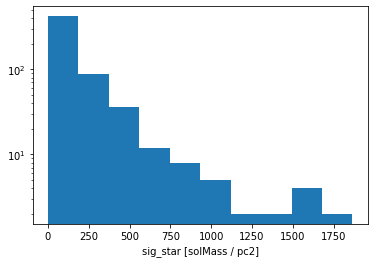

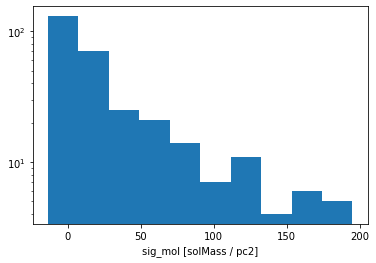

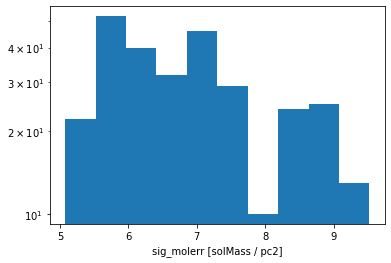

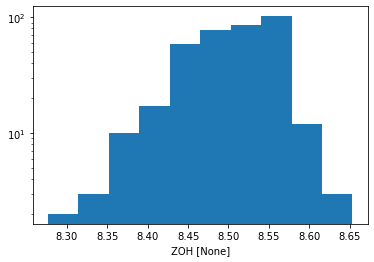

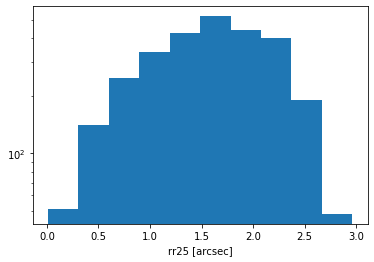

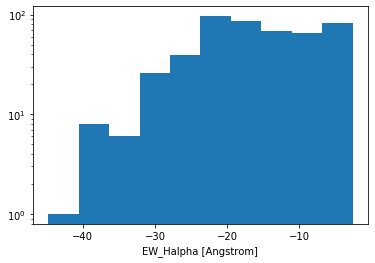

In [7]:
for column in ['sig_star', 'sig_mol', 'sig_molerr', 'ZOH', 'rr25', 'EW_Halpha']:
    not_nan = (~np.isnan(cotab[column]))
    plt.hist(cotab[column][not_nan],log=True)
    plt.xlabel(column+' ['+str(cotab[column].unit)+']')
    plt.show()
    plt.close()

## Make the plots

In [8]:
# Plot limits and labels
xlabel = '$\Sigma_*\ [M_\odot\, pc^{-2}]$'
ylabel = '$\Sigma_{H2}\ [M_\odot\, pc^{-2}]$'
xrange = [0, 4]
yrange = [0, 4]

# 10% line
xsca = np.logspace(xrange[0],xrange[1],100)
ysca = xsca/10.

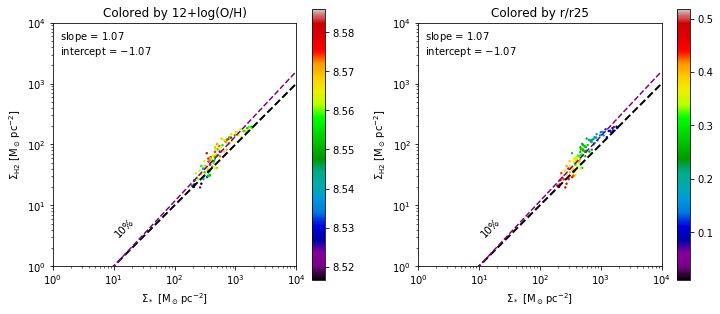

In [9]:
# Scatter X vs Y colored by Z, CO detections only
fig, ax = plt.subplots(1,2,figsize=(12,5))
cmap = plt.cm.get_cmap('nipy_spectral')
for i, zcolumn in enumerate(['ZOH', 'rr25']):
    xdata = cotab['sig_star']
    ydata = cotab['sig_mol']
    zdata = cotab[zcolumn]
    goodidx = (xdata>0) & (ydata>0) & (zdata>0) & (cotab['rr25']<1)
    detidx = goodidx & (cotab['sig_mol']>3*cotab['sig_molerr'])
    xdata = xdata[detidx]
    ydata = ydata[detidx]
    zdata = zdata[detidx]
    sc = ax[i].scatter(xdata, ydata, marker='o', c=zdata, edgecolors='none', s=6, cmap=cmap)
    # Plot 10% line
    ax[i].plot(xsca, ysca, linestyle='--', lw=2, color='k')
    ax[i].text(10, 3, '10%', rotation=45)
    # Plot colorbar
    fig.colorbar(sc, ax=ax[i])
    # Plot linear regression
    sorted=np.argsort(xdata)
    m, b, rval, pval, std_err = stats.linregress(np.log10(xdata[sorted]),
        np.log10(ydata[sorted]))
    ymod = b+m*np.log10(xsca)
    ax[i].plot(xsca, 10**(ymod), linestyle='--', color='purple')
    ax[i].text(0.03,0.93,'slope = $%4.2f$' % m,size=10,transform=ax[i].transAxes)
    ax[i].text(0.03,0.87,'intercept = $%4.2f$' % b,size=10,transform=ax[i].transAxes)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    if i==0:
        title='12+log(O/H)'
    else:
        title='r/r25'
    ax[i].set_title('Colored by '+title)
    ax[i].set_xlim(10**xrange[0], 10**xrange[1])
    ax[i].set_ylim(10**yrange[0], 10**yrange[1])
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel(ylabel)
    ax[i].set_aspect('equal')
plt.show()

Excluding 2707 invalid values
Number of detection points: 102


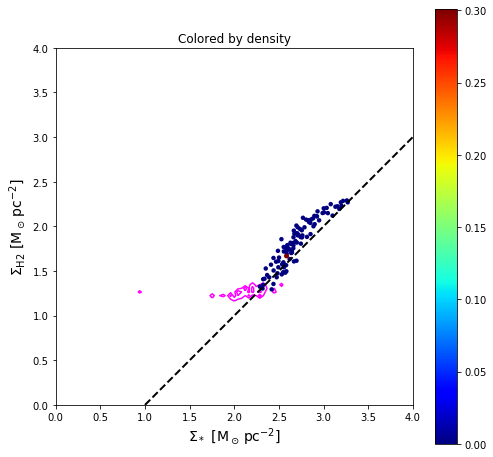

In [10]:
# Histogram of X vs Y
det = ((~np.isnan(cotab['sig_star'])) & 
       (~np.isnan(cotab['sig_mol'])) & 
       (cotab['sig_mol']>3*cotab['sig_molerr']) &
       (cotab['sig_star']>0))
print('Excluding {} invalid values'.format(len(np.nonzero(~det)[0])))
print('Number of detection points:',len(np.nonzero(det)[0]))
x_det, y_det, z_det, *hist = xy2hist(cotab['sig_star'][det], cotab['sig_mol'][det], log=True)

# Plot the detections as colored points
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap=cm, zorder=2)

# Plot the upper limits as contours
nbins = 100
xbins = np.linspace(xrange[0], xrange[1], nbins)
ybins = np.linspace(yrange[0], yrange[1], nbins)
ulim = ((cotab['sig_star']>0) & 
        ((np.isnan(cotab['sig_mol'])) | (cotab['sig_mol']<3*cotab['sig_molerr'])))
H2, xedges, yedges = np.histogram2d(np.log10(cotab['sig_star'][ulim]),
                                      np.log10(3*cotab['sig_molerr'][ulim]),
                                      bins=(xbins,ybins))
H2 = np.transpose(H2)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
levels = [2, 5, 10, 20, 50, 100, 200]
cmap = ax.contour(H2, colors='magenta', extent=extent, levels=levels, zorder=1)

# Plot the 10% line
xsca = np.linspace(1,4,10)
ysca = xsca - 1
ax.plot(xsca, ysca, linestyle='--', lw=2, color='k')

plt.xlabel(xlabel,fontsize=14)
plt.ylabel(ylabel,fontsize=14)
ax.set_title('Colored by density')
ax.set_aspect('equal')
plt.colorbar(sc)